In [129]:
cd /data/convchess/src/play/

/data/convchess/src/play


In [130]:
import keras
import cPickle as pkl
import sys
import numpy as np
sys.setrecursionlimit(40000)
class CNN_evaluator:
	"""docstring for CNN_evaluation"""
	def __init__(self, model_file):
		self.model = pkl.load(open(model_file, 'r'))

	def evaluate(self, im):
		return self.model.predict(np.asarray([im]), verbose=0)[0][0]

	def evaluate_batch(self, batch):
		#batch is much faster than one individually
		#print batch
		return self.model.predict(np.asarray(batch), verbose=0, batch_size=1024)[:,0]

In [132]:
evaluator = CNN_evaluator('regression_models/model_g07_bp_largedeep.pkl')

In [133]:
from play4 import *

In [134]:
import sunfish
pos = sunfish.Position(sunfish.initial, 0, (True,True), (True,True), 0, 0)
bb = pos_board_to_bitboard(pos.board)
print bb
im = convert_bitboard_to_image(bb)
im = np.rollaxis(im, 2, 0)
print im

r n b q k b n r 
p p p p p p p p 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
P P P P P P P P 
R N B Q K B N R
[[[ 0.  0.  0.  0.  0.  0.  0.  0.]
  [-1. -1. -1. -1. -1. -1. -1. -1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]]

 [[-1.  0.  0.  0.  0.  0.  0. -1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  1.]]

 [[ 0. -1.  0.  0.  0.  0. -1.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  1.  0.  0.  0.  0.  1.  0

In [135]:
evaluator.evaluate(im)

0.0015796223888173699

In [136]:
from example_moves.draw_board.draw import *

In [137]:
cd example_moves/draw_board/

/data/convchess/src/util/draw_board


In [138]:
def parseFEN(fen):
	""" Parses a string in Forsyth-Edwards Notation into a Position """
	board, color, castling, enpas, hclock, fclock = fen.split()
	board = re.sub('\d', (lambda m: '.'*int(m.group(0))), board)
	board = ' '*19+'\n ' + '\n '.join(board.split('/')) + ' \n'+' '*19
	wc = ('Q' in castling, 'K' in castling)
	bc = ('k' in castling, 'q' in castling)
	ep = sunfish.parse(enpas) if enpas != '-' else 0
	score = sum(sunfish.pst[p][i] for i,p in enumerate(board) if p.isupper())
	score -= sum(sunfish.pst[p.upper()][i] for i,p in enumerate(board) if p.islower())
	pos = sunfish.Position(board, score, wc, bc, ep, 0)
	return pos if color == 'w' else pos.rotate()
def posboard_to_im(pos):
    bb = pos_board_to_bitboard(pos)
    im = convert_bitboard_to_image(bb)
    im = np.rollaxis(im,2,0)
    return im
def fen_to_im(fen):
    pos = parseFEN(fen)
    return posboard_to_im(pos.board)
def image_board(pos):
    plt.xticks(range(8), string.lowercase)
    ax = plt.imshow(draw_board(posboard_to_im(pos)), cmap=cm.Greys_r)
    f = plt.gcf()
    f.set_size_inches(6,6)
    ax.set_extent([-0.5,7.5,0.5,8.5])
    plt.show()

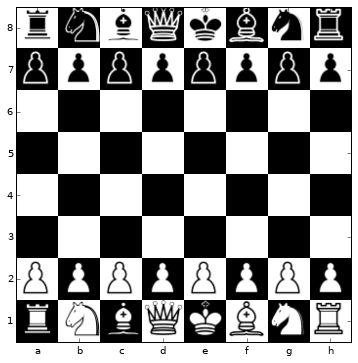

In [139]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
image_board(pos.board)

In [140]:
def top_bottom_moves(fen, top=5, bottom=5):
    pos = parseFEN(fen)
    bb = pos_board_to_bitboard(pos.board)
    image_board(pos.board)
    im = convert_bitboard_to_image(bb)
    im = np.rollaxis(im, 2, 0)
    print "\tCurrent evaluation: %f"%evaluator.evaluate(im)
    future_boards = []
    pos_children = []
    moves = list(pos.genMoves())
    print "Total %d moves possible"%len(moves)
    for move in moves:
        pos_child = pos.move(move).rotate()
        bb = pos_board_to_bitboard(pos_child.board)
        im = convert_bitboard_to_image(bb)
        im = np.rollaxis(im, 2, 0)
        future_boards.append(im)
        pos_children.append(pos_child.board)
    #future_boards = np.asarray(future_boards)
    values = evaluator.evaluate_batch(future_boards)
    poschildren_vals = sorted(zip(pos_children , moves, values), key=operator.itemgetter(2), reverse=True)
    print "TOP 5 Moves"
    for pos_child, move, value in poschildren_vals[0:top]:
        image_board(pos_child)
        print '\t',sunfish.render(move[0]) + sunfish.render(move[1]), value 
    print "WORST 5 Moves"
    for pos_child, move, value in poschildren_vals[-bottom:]:
        image_board(pos_child)
        print '\t',sunfish.render(move[0]) + sunfish.render(move[1]), value 

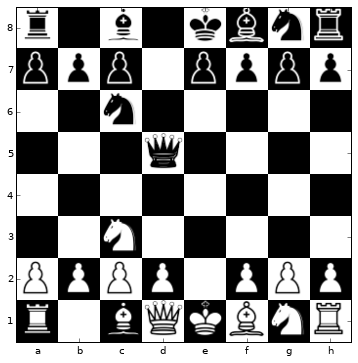

	Current evaluation: 0.003406
Total 32 moves possible
TOP 5 Moves


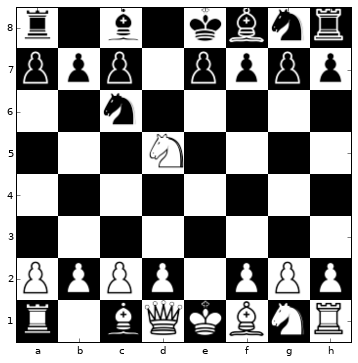

	c3d5 0.0545512847602


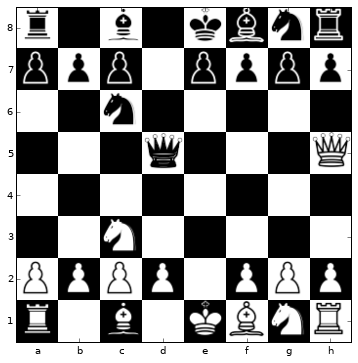

	d1h5 0.014403430745


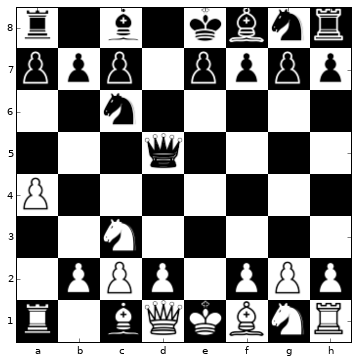

	a2a4 0.0119769489393


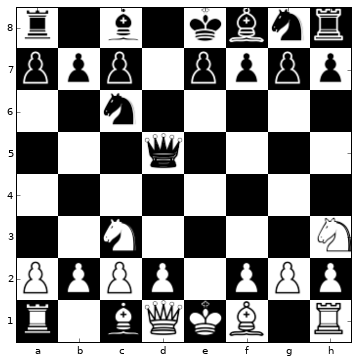

	g1h3 0.0115632256493


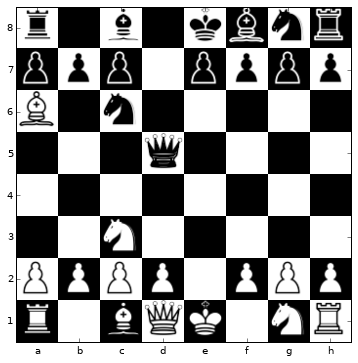

	f1a6 0.0110727511346
WORST 5 Moves


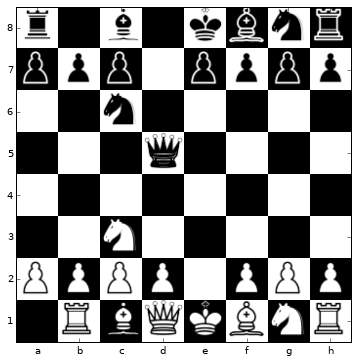

	a1b1 -0.000657614204101


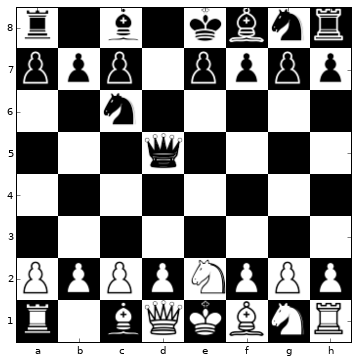

	c3e2 -0.00339178182185


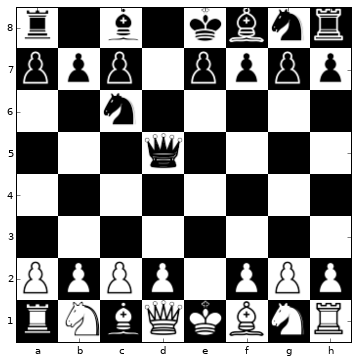

	c3b1 -0.00497451797128


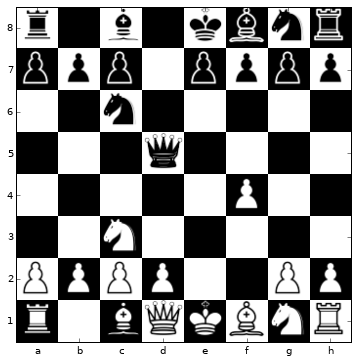

	f2f4 -0.00507037481293


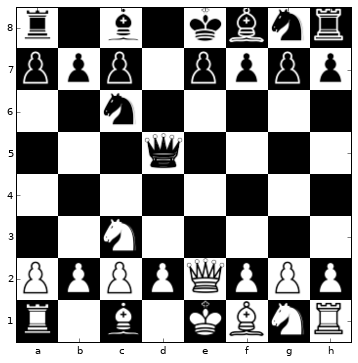

	d1e2 -0.0093725817278


In [142]:
'''
Killing Queen with a knight
(Works)
'''
top_bottom_moves('r1b1kbnr/ppp1pppp/2n5/3q4/8/2N5/PPPP1PPP/R1BQKBNR w KQkq - 0 4')

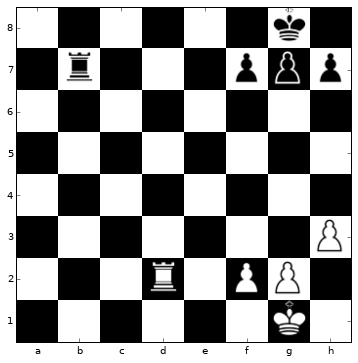

	Current evaluation: 0.005135
Total 19 moves possible
TOP 5 Moves


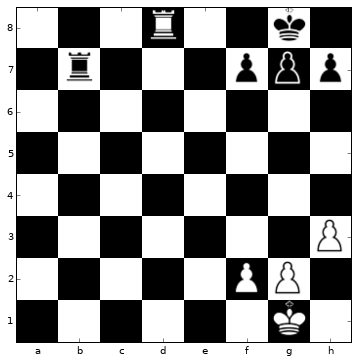

	d2d8 0.0197097081691


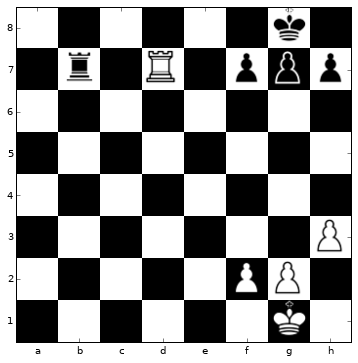

	d2d7 0.0104831121862


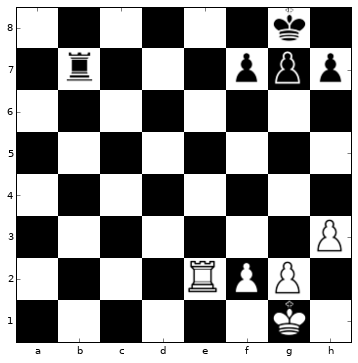

	d2e2 0.0095460517332


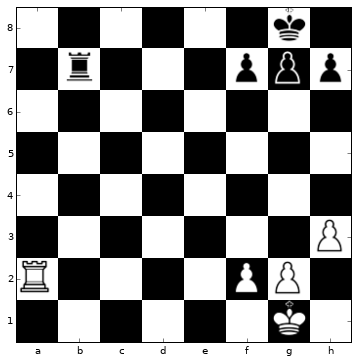

	d2a2 0.00832254067063


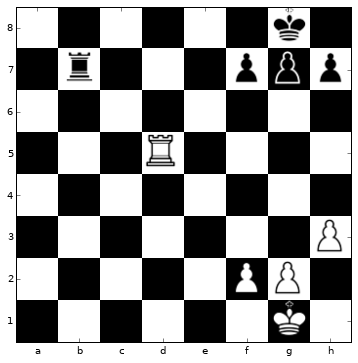

	d2d5 0.00792756490409
WORST 5 Moves


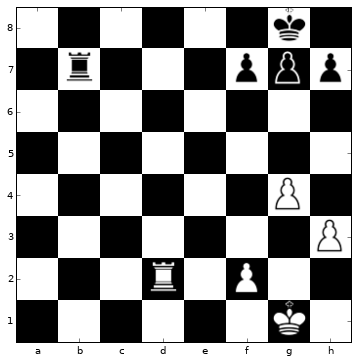

	g2g4 0.00263008615002


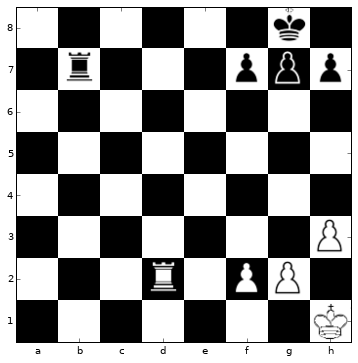

	g1h1 0.00203793123364


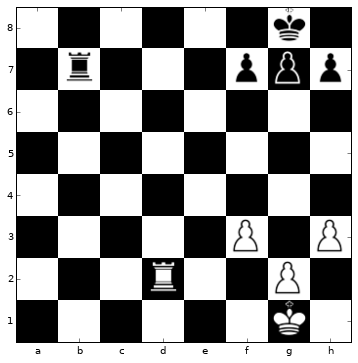

	f2f3 0.00103432091419


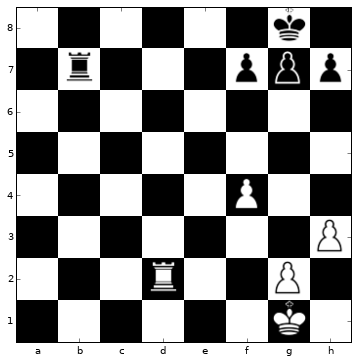

	f2f4 -0.00156242738012


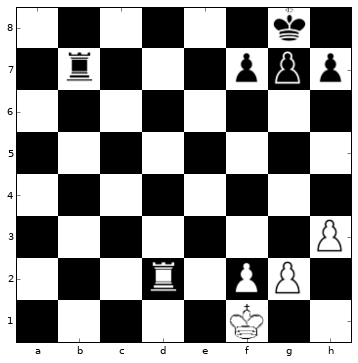

	g1f1 -0.00216535036452


In [123]:
'''
Checkmating with a rook
(Works)
'''
top_bottom_moves('6k1/1r3ppp/8/8/8/7P/3R1PP1/6K1 w - - 0 0')

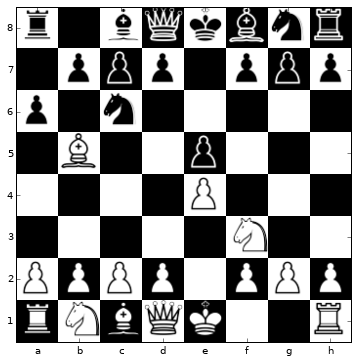

	Current evaluation: -0.002677
Total 32 moves possible
TOP 5 Moves


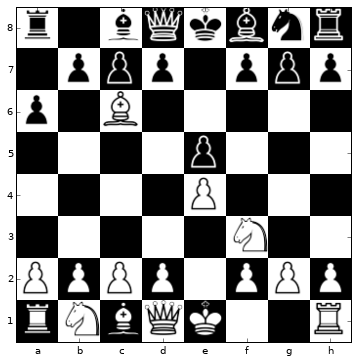

	b5c6 0.0134096052498


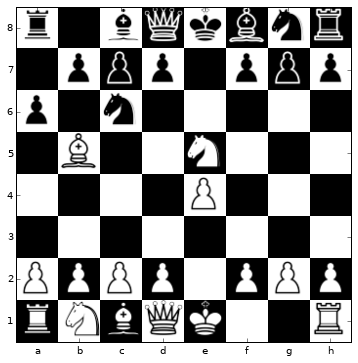

	f3e5 0.0112700033933


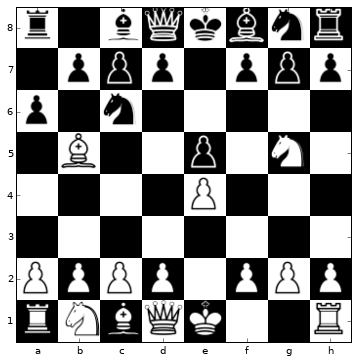

	f3g5 0.00664248364046


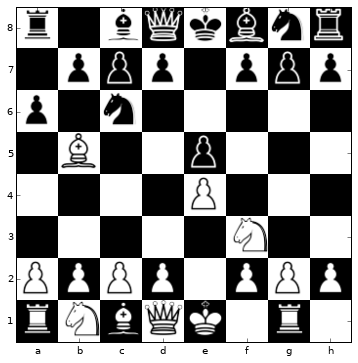

	h1g1 0.00202503800392


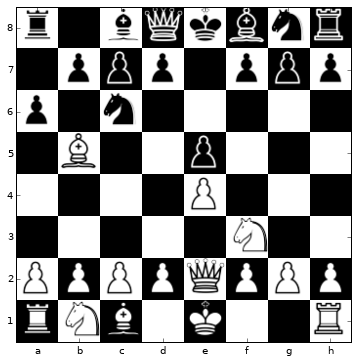

	d1e2 0.000874900026247
WORST 5 Moves


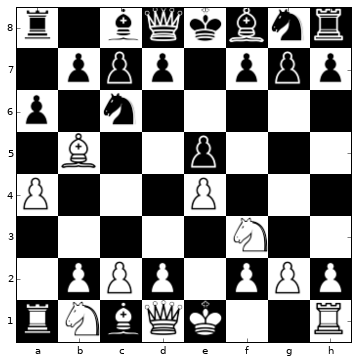

	a2a4 -0.00502909859642


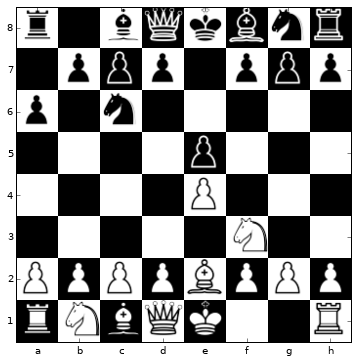

	b5e2 -0.00531035801396


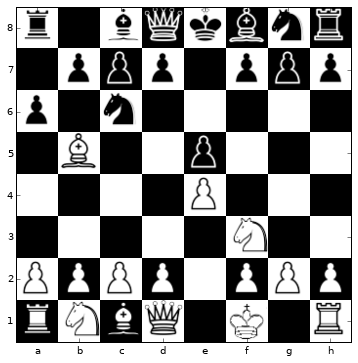

	e1f1 -0.00641573453322


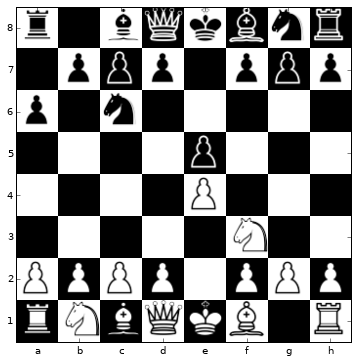

	b5f1 -0.00652421219274


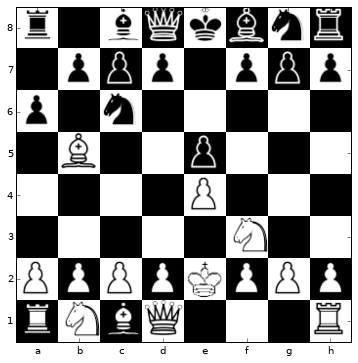

	e1e2 -0.0114413453266


In [124]:
'''
 Trading the knight with a bishop
'''
top_bottom_moves('r1bqkbnr/1ppp1ppp/p1n5/1B2p3/4P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 0')

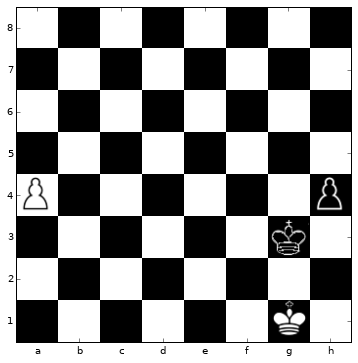

	Current evaluation: -0.015291
Total 6 moves possible
TOP 5 Moves


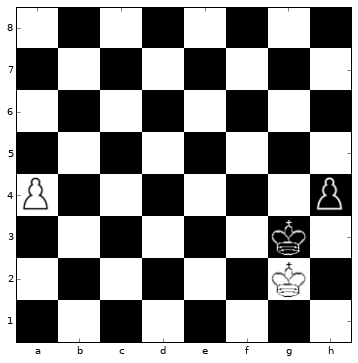

	g1g2 0.000877474201843


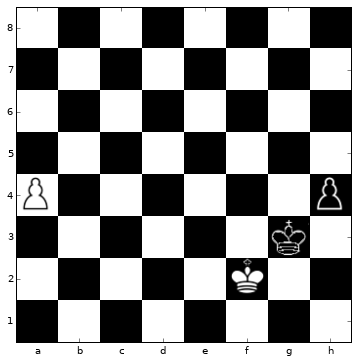

	g1f2 0.000272083096206


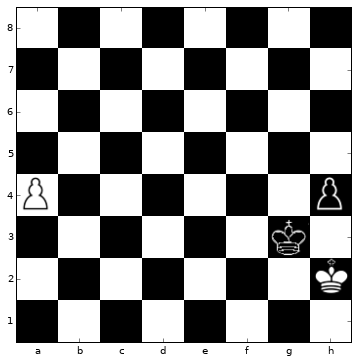

	g1h2 -0.00981879793108


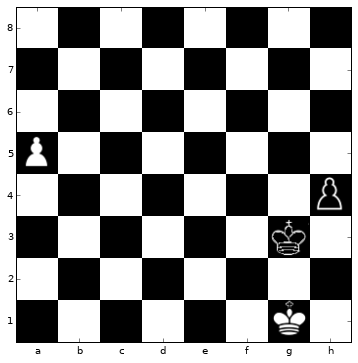

	a4a5 -0.0149829080328


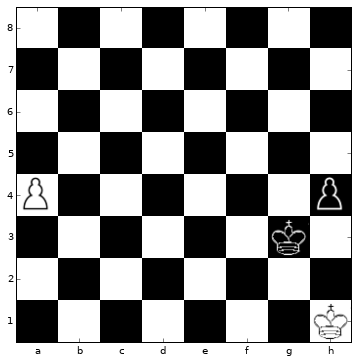

	g1h1 -0.0227952189744
WORST 5 Moves


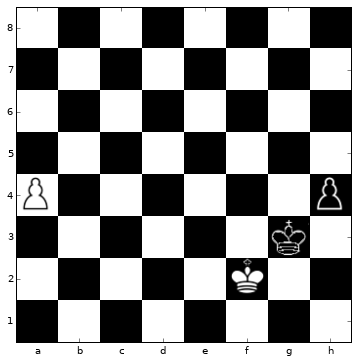

	g1f2 0.000272083096206


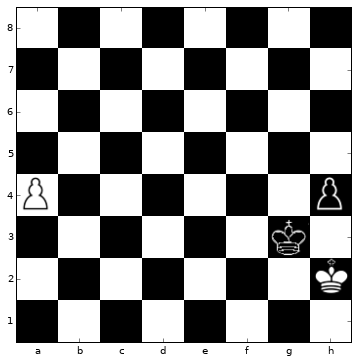

	g1h2 -0.00981879793108


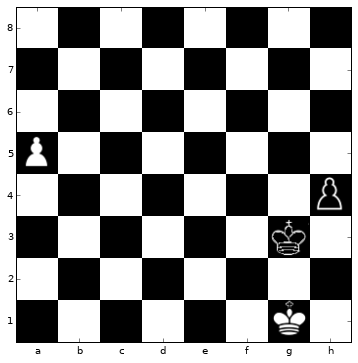

	a4a5 -0.0149829080328


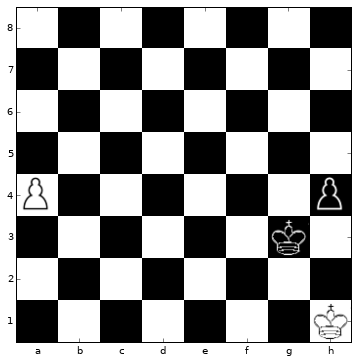

	g1h1 -0.0227952189744


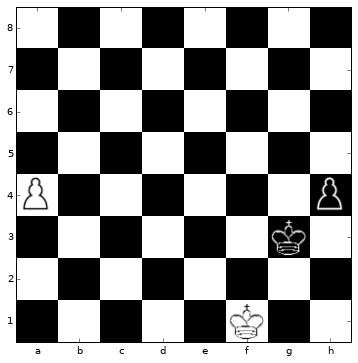

	g1f1 -0.0248968098313


In [125]:
'''
Runaway Pawn
'''
top_bottom_moves('8/8/8/8/P6p/6k1/8/6K1 w - - 0 0')

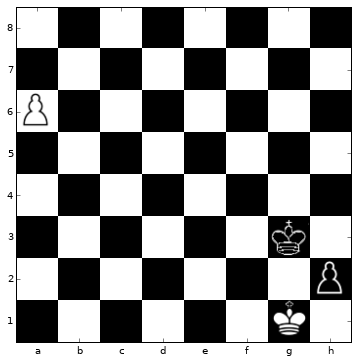

	Current evaluation: -0.010196
Total 6 moves possible
TOP 5 Moves


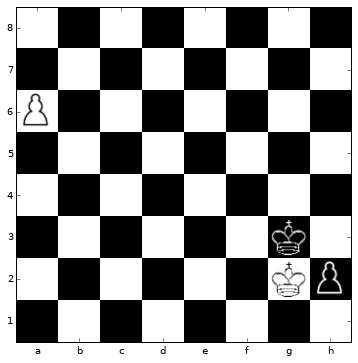

	g1g2 0.00576221710071


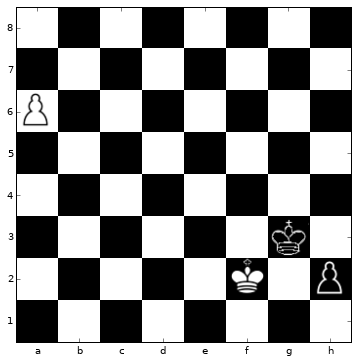

	g1f2 0.0055610910058


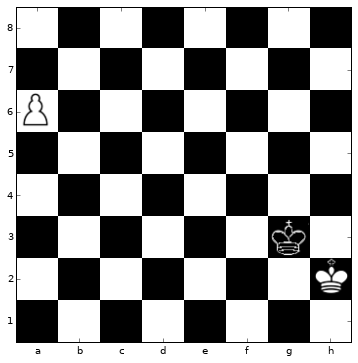

	g1h2 0.00482838880271


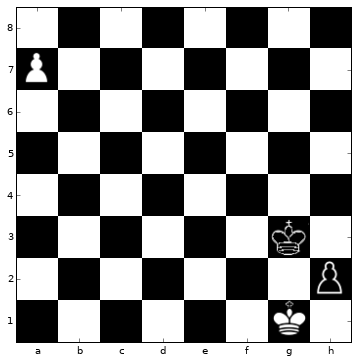

	a6a7 -0.0123441703618


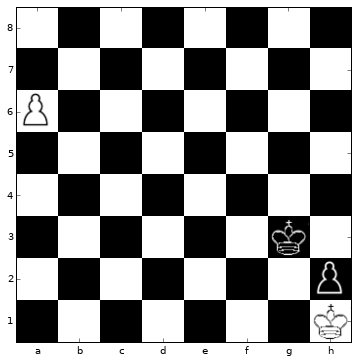

	g1h1 -0.0175688508898
WORST 5 Moves


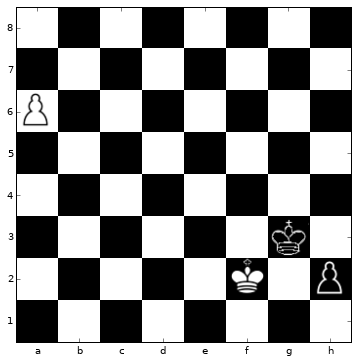

	g1f2 0.0055610910058


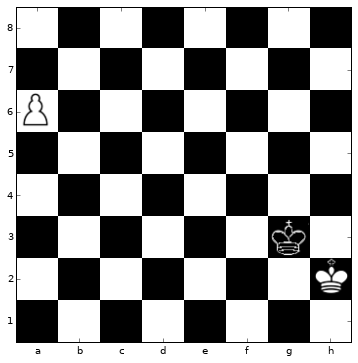

	g1h2 0.00482838880271


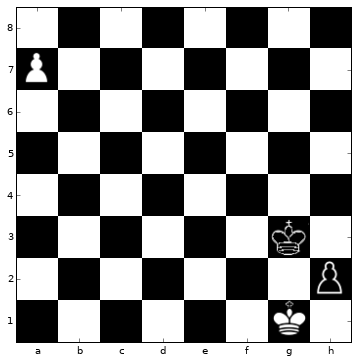

	a6a7 -0.0123441703618


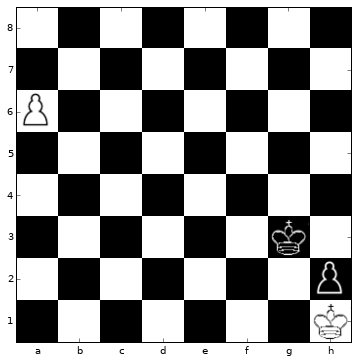

	g1h1 -0.0175688508898


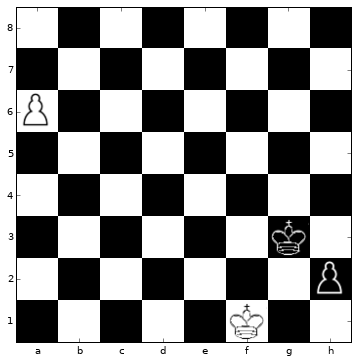

	g1f1 -0.0194953456521


In [126]:
'''
Check and Blocking a promotion
'''
fen = '8/8/P7/8/8/6k1/7p/6K1 w - - 0 0'
top_bottom_moves(fen)

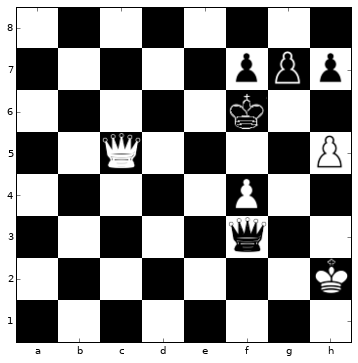

	Current evaluation: -0.023971
Total 31 moves possible
TOP 5 Moves


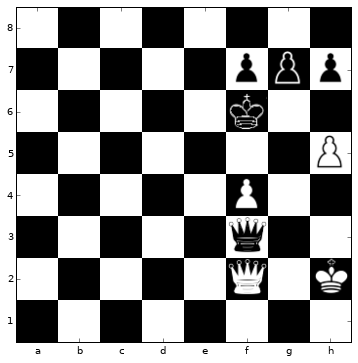

	c5f2 -0.00525758694857


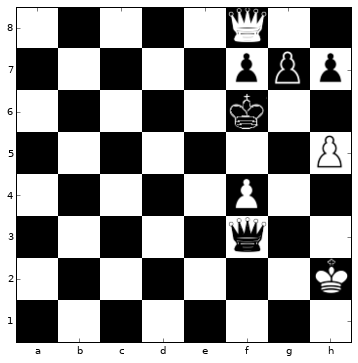

	c5f8 -0.00948088429868


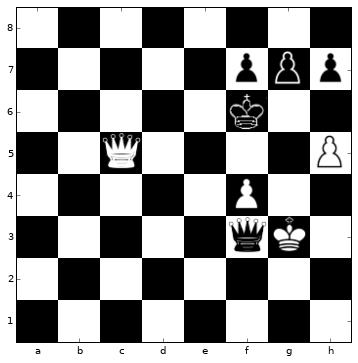

	h2g3 -0.0105619179085


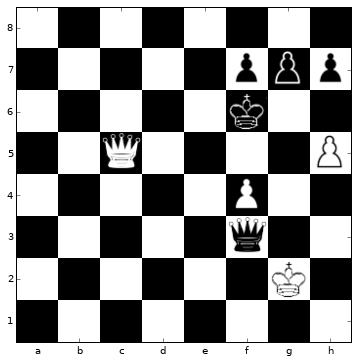

	h2g2 -0.0151042882353


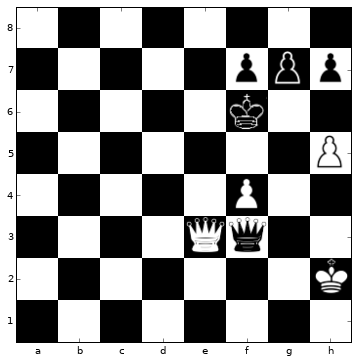

	c5e3 -0.017306458205
WORST 5 Moves


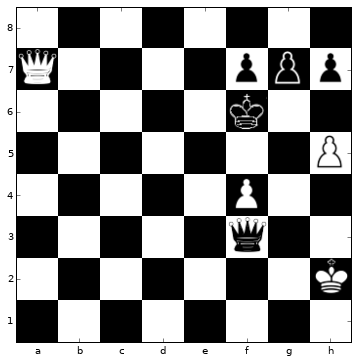

	c5a7 -0.0406500063837


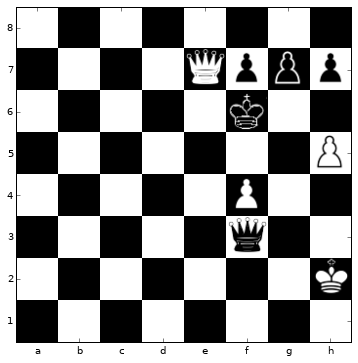

	c5e7 -0.0420409888029


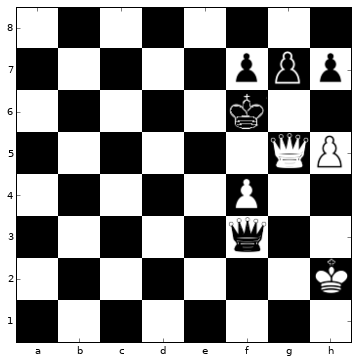

	c5g5 -0.0421368405223


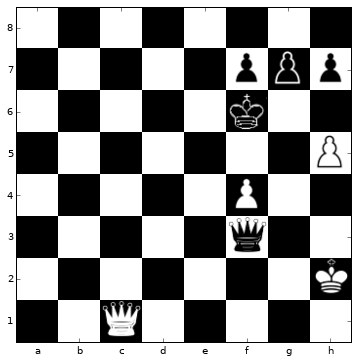

	c5c1 -0.0430180281401


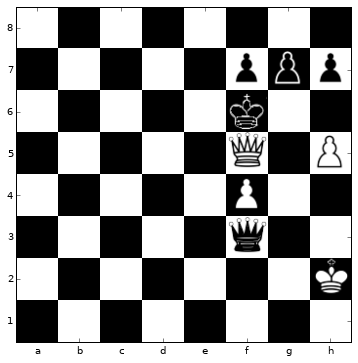

	c5f5 -0.0446254871786


In [127]:
'''
Mate in 1
'''
fen='8/5ppp/5k2/2Q4P/5P2/5q2/7K/8 w - - 0 0'
top_bottom_moves(fen)

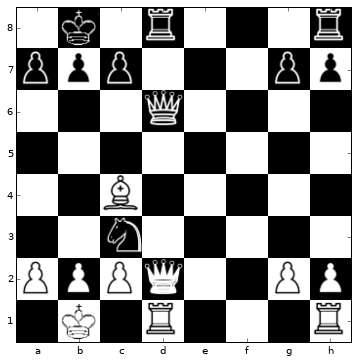

	Current evaluation: -0.007698
Total 41 moves possible
TOP 5 Moves


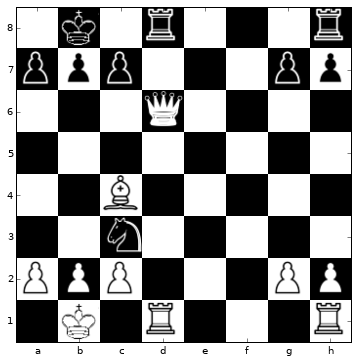

	d2d6 0.139244303107


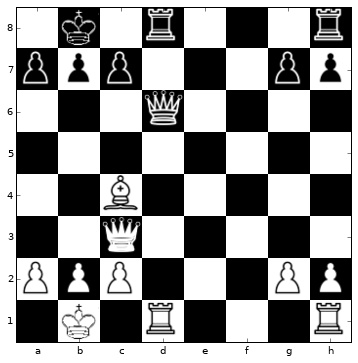

	d2c3 0.0400848388672


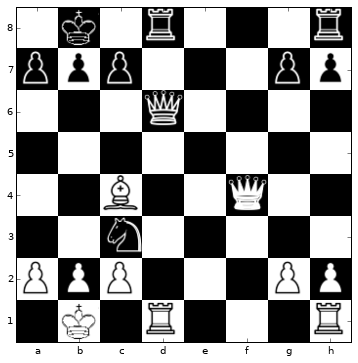

	d2f4 0.0280776321888


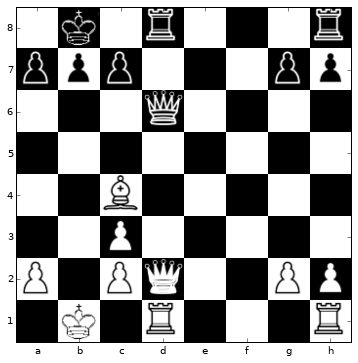

	b2c3 0.0228184666485


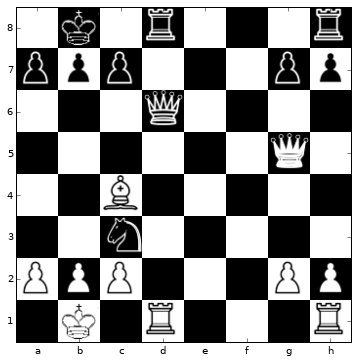

	d2g5 0.0207833554596
WORST 5 Moves


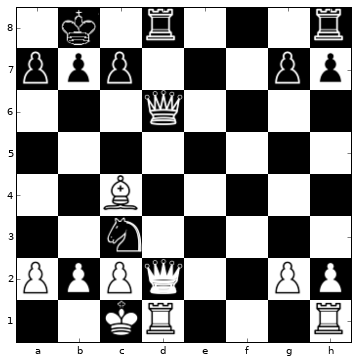

	b1c1 -0.0201652348042


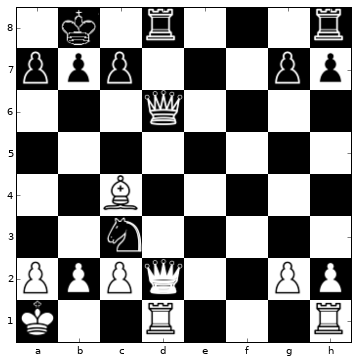

	b1a1 -0.0206535663456


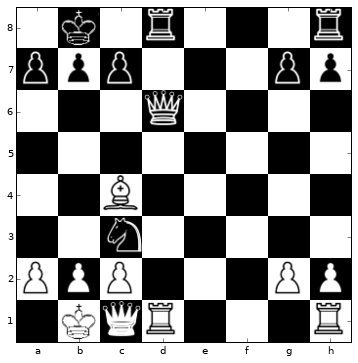

	d2c1 -0.0241448245943


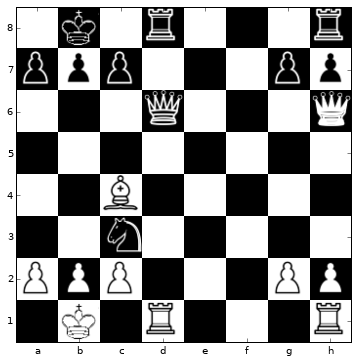

	d2h6 -0.0248840972781


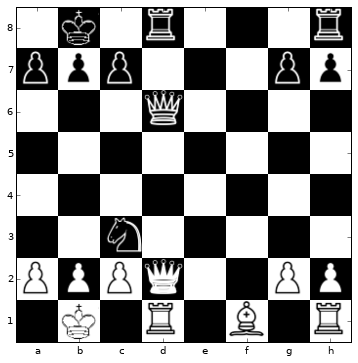

	c4f1 -0.0262713767588


In [143]:
'''
Check and fork by the knight
'''
fen='1k1r3r/ppp3pp/3q4/8/2B5/2n5/PPPQ2PP/1K1R3R w - - 0 0'
top_bottom_moves(fen)

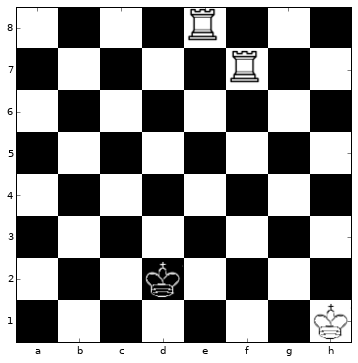

	Current evaluation: 0.227653
Total 31 moves possible
TOP 5 Moves


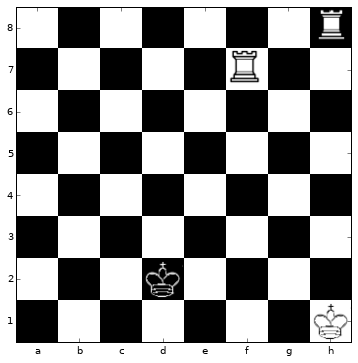

	e8h8 0.307574003935


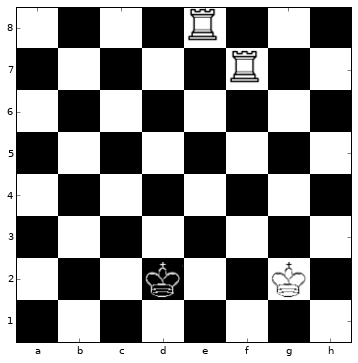

	h1g2 0.279015421867


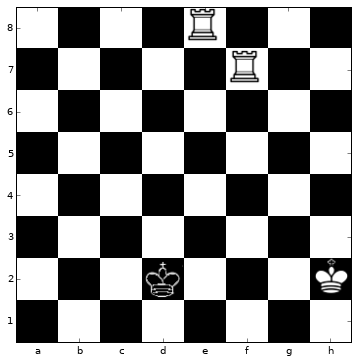

	h1h2 0.25475075841


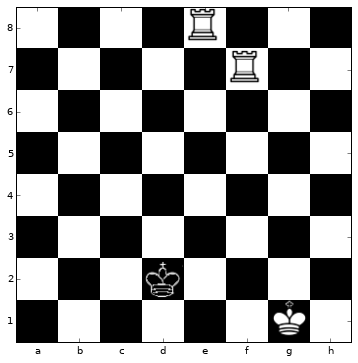

	h1g1 0.244157657027


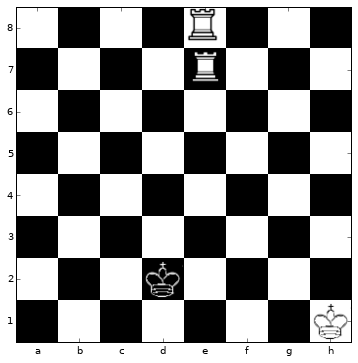

	f7e7 0.242229655385
WORST 5 Moves


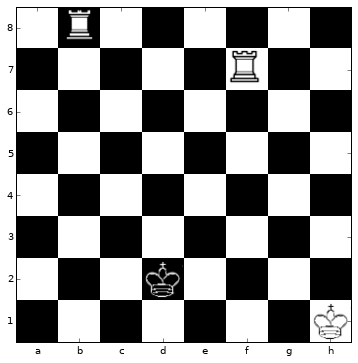

	e8b8 0.180342525244


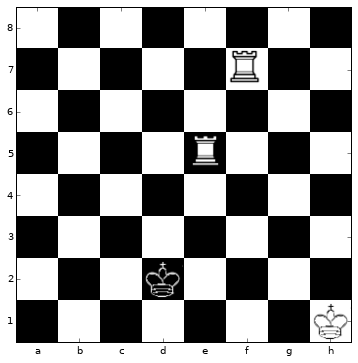

	e8e5 0.179203212261


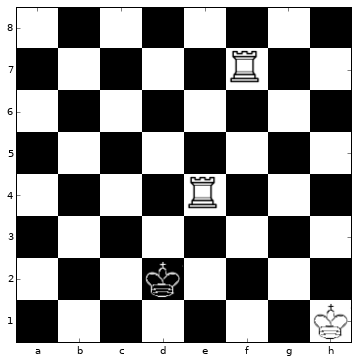

	e8e4 0.179086685181


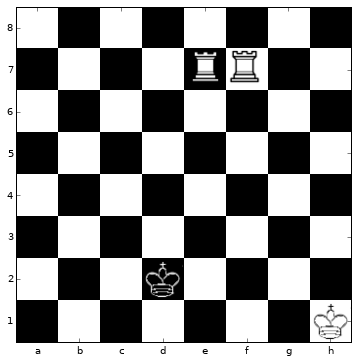

	e8e7 0.178259670734


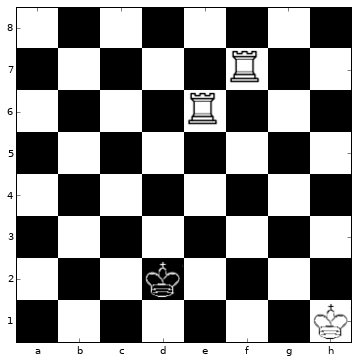

	e8e6 0.162149891257


In [144]:
'''
Pushing the broom
'''
fen='4R3/5R2/8/8/8/8/3k4/7K w - - 0 0'
top_bottom_moves(fen)

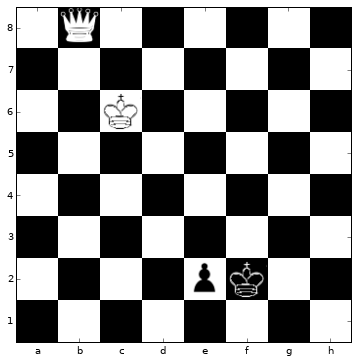

	Current evaluation: 0.132124
Total 29 moves possible
TOP 5 Moves


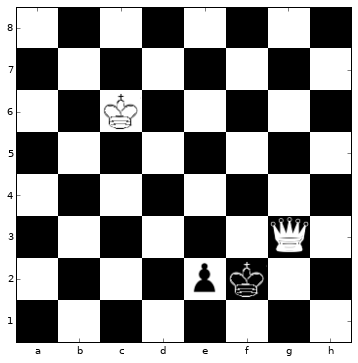

	b8g3 0.232341885567


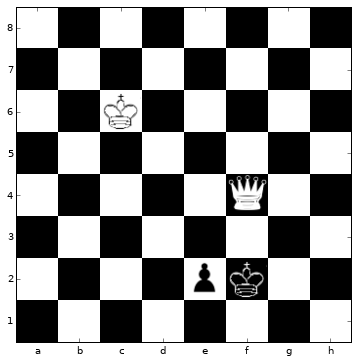

	b8f4 0.220576122403


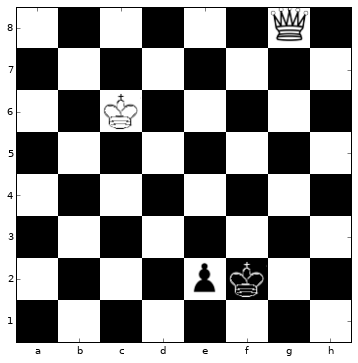

	b8g8 0.212574183941


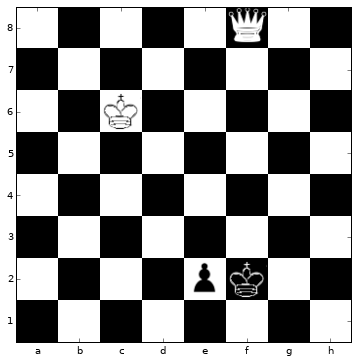

	b8f8 0.208147808909


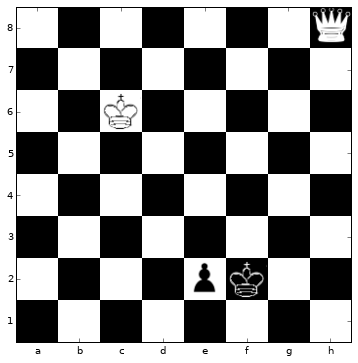

	b8h8 0.205039218068
WORST 5 Moves


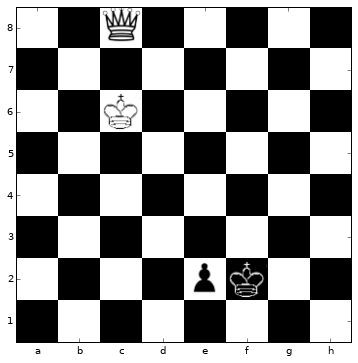

	b8c8 0.131534919143


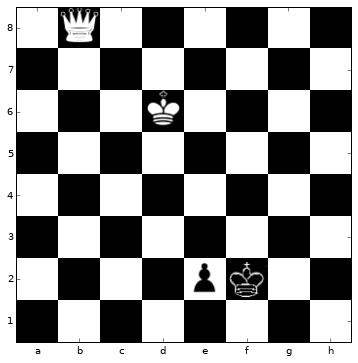

	c6d6 0.129832103848


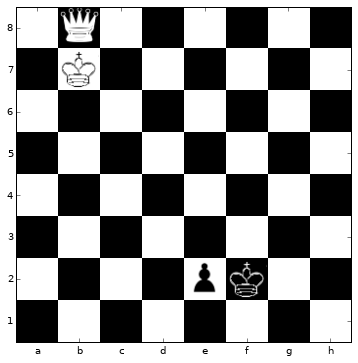

	c6b7 0.121259056032


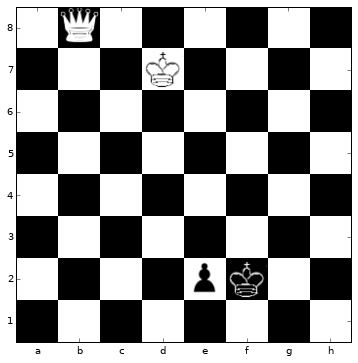

	c6d7 0.109470196068


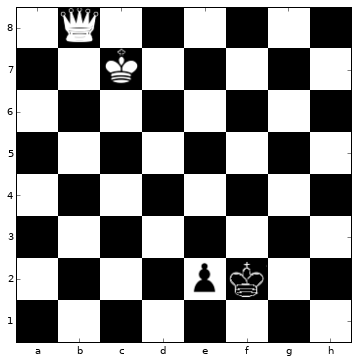

	c6c7 0.105199843645


In [145]:
'''
Queen King vs King Pawn
'''
fen = '1Q6/8/2K5/8/8/8/4pk2/8 w - - 0 0'
top_bottom_moves(fen)

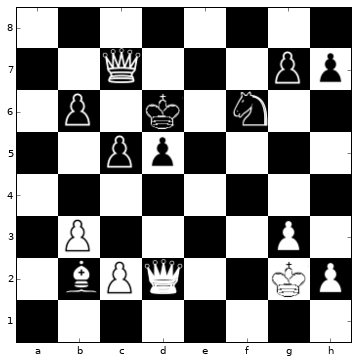

	Current evaluation: -0.022609
Total 34 moves possible
TOP 5 Moves


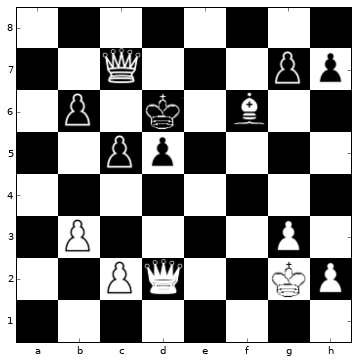

	b2f6 0.0331075489521


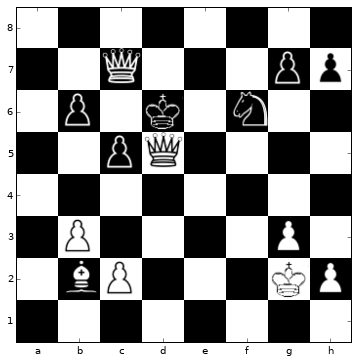

	d2d5 0.0303655806929


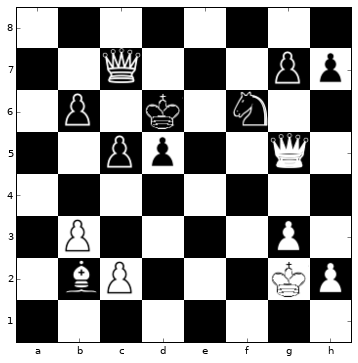

	d2g5 0.0135372616351


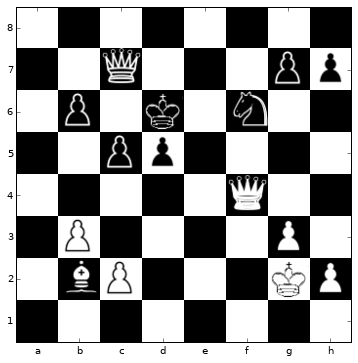

	d2f4 0.0116871511564


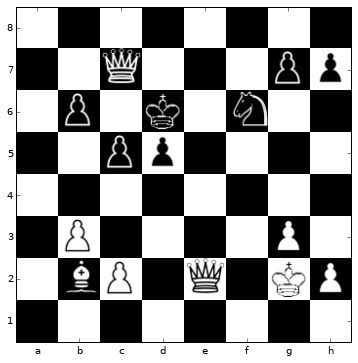

	d2e2 0.00281526707113
WORST 5 Moves


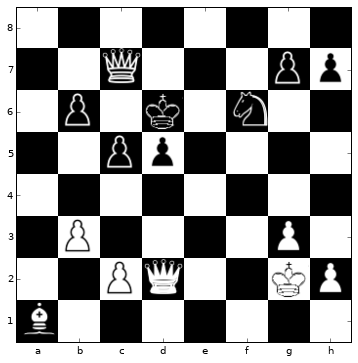

	b2a1 -0.0309130325913


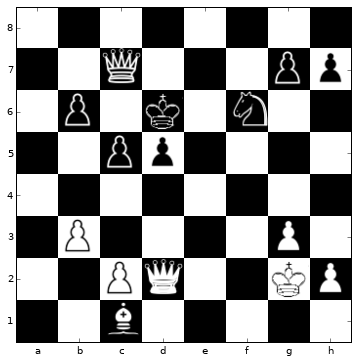

	b2c1 -0.0322334840894


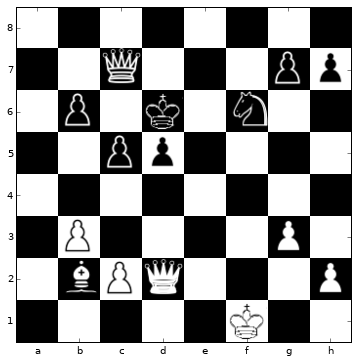

	g2f1 -0.033534001559


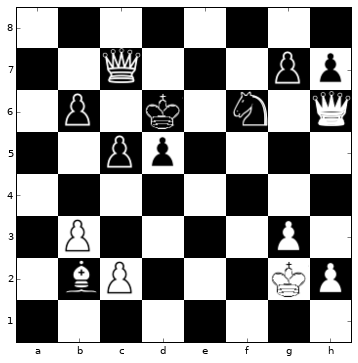

	d2h6 -0.0337856337428


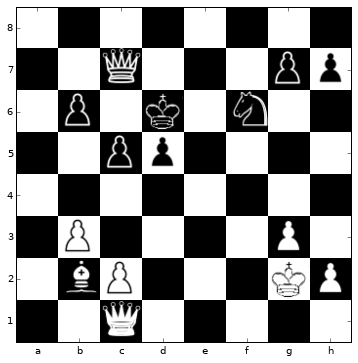

	d2c1 -0.0525860860944


In [147]:
fen='8/2q3pp/1p1k1n2/2pp4/8/1P4P1/1BPQ2KP/8 w - - 0 0'
top_bottom_moves(fen)

In [ ]:

top_bottom_moves(fen)

In [141]:
fen='8/2q3pp/1p1k1n2/2pp4/8/1P4P1/1BPQ2KP/8 w - - 0 0'
move = top_bottom_moves(fen, 1)
pos = parseFEN(fen)
print pos.board
print evaluator.evaluate(np.rollaxis(convert_bitboard_to_image(pos.board), 2, 0))
move= "c5e5"
crdn = (sunfish.parse(move[0:2]), sunfish.parse(move[2:4]))
print pos.move(crdn).rotate().board
print evaluator.evaluate(np.rollaxis(convert_bitboard_to_image(pos.move(crdn).rotate().board), 2, 0))
print pos.move(crdn).board
print evaluator.evaluate(np.rollaxis(convert_bitboard_to_image(pos.move(crdn).board), 2, 0))


                   
 ........
 .....ppp
 .....k..
 ..Q....P
 .....P..
 .....q..
 .......K
 ........ 
                   
-0.0676881596446
                   
 ........
 .....ppp
 .....k..
 ....Q..P
 .....P..
 .....q..
 .......K
 ........ 
                   
-0.0355458296835
                   
 ........ 
k....... 
..Q..... 
..p..... 
p..q.... 
..K..... 
PPP..... 
........ 
                   
0.0441848859191


In [102]:
import h5py as h5
y = h5.File("/data/ConvChess/data/all_data_g07_pb_h5/piece.h5")
y = y['label']

In [103]:
y = y[0:1000000]
print np.std(y)
print np.var(y)

0.200632
0.0402531


In [108]:
evaluator = CNN_evaluator('regression_models/model_CvC_g09.pkl')

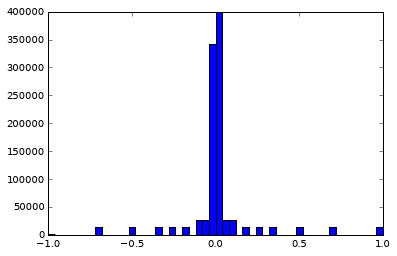

In [104]:
%matplotlib inline
import matplotlib.cm as cm
plt.hist(y, bins=50)
plt.show()